# Summary

Train a Generative Adverserial Network (GAN).

----

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

In [2]:
%run _imports.ipynb

Setting the PACKAGE_VERSION environment variable.
Setting the DOCS_SECRET_KEY environment variable.
Setting the PYTHON_VERSION environment variable.
Setting the SPARK_MASTER environment variable.
Setting the SPARK_ARGS environment variable.
Setting the DB_TYPE environment variable.
Setting the DB_PORT environment variable.


2018-03-09 15:33:37.254271


In [3]:
%run _settings.ipynb

In [4]:
from typing import NamedTuple

import h5py
from sklearn import metrics

In [5]:
import random
random.seed(42)

In [6]:
import pagnn

In [7]:
pagnn.settings.CUDA = False

In [8]:
NOTEBOOK_NAME = 'train_neural_network'
NOTEBOOK_PATH = Path(NOTEBOOK_NAME).absolute()
NOTEBOOK_PATH.mkdir(exist_ok=True)

# Parameters

In [8]:
import pagnn.scripts.train_gan

In [9]:
!python {pagnn.scripts.train_gan.__file__} --help

usage: train_gan.py [-h] [--rootdir ROOTDIR] [--datadir DATADIR]
                    [--loss_name LOSS_NAME] [--lr LR]
                    [--weight_decay WEIGHT_DECAY] [--n_filters N_FILTERS]
                    [--batch-size BATCH_SIZE]
                    [--training-methods TRAINING_METHODS]
                    [--training-min-seq-identity TRAINING_MIN_SEQ_IDENTITY]
                    [--training-permutations {seq,adj,seq.adj}]
                    [--validation-methods VALIDATION_METHODS]
                    [--validation-num-sequences VALIDATION_NUM_SEQUENCES]
                    [--validation-min-seq-identity VALIDATION_MIN_SEQ_IDENTITY]
                    [--gpu GPU] [--tag TAG] [--resume]
                    [--num-aa-to-process NUM_AA_TO_PROCESS]
                    [-n NUM_CONCURRENT_JOBS]

optional arguments:
  -h, --help            show this help message and exit
  --rootdir ROOTDIR
  --datadir DATADIR
  --loss_name LOSS_NAME
  --lr LR
  --weight_decay WEIGHT_DECAY
  --n_

In [10]:
!echo python {pagnn.scripts.train_gan.__file__} \
    --rootdir {NOTEBOOK_PATH} \
    --datadir {os.environ['DATABIN_DIR']}/adjacency-net \
    --n_filters 64 \
    --validation-min-seq-identity 80 \
    --gpu -1 \
    --training-methods permute \
    --training-permutations seq \
    --validation-methods exact \
    --validation-min-seq-identity 80 \
    --tag test_1

python /home/kimlab1/strokach/working/pagnn/pagnn/scripts/train_gan.py --rootdir /home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/train_neural_network --datadir /home/kimlab2/database_data/databin/adjacency-net --n_filters 64 --validation-min-seq-identity 80 --gpu -1 --training-methods permute --training-permutations seq --validation-methods exact --validation-min-seq-identity 80 --tag test_1


In [1]:
import logging
from typing import List, Optional
import math
from collections import defaultdict
import itertools

import numpy as np
import scipy as sp
import torch
import torch.nn.functional as F
from numba import jit
from scipy import sparse
from torch.autograd import Variable

from pagnn import settings
from pagnn.types import DataSetGAN, DataVarGAN
from pagnn.utils import expand_adjacency, get_seq_array, to_sparse_tensor

from contextlib import contextmanager

import numpy as np
import pytest
from scipy import sparse
from torch.autograd import Variable

from pagnn import settings
from pagnn.datavargan import pool_adjacency_mat3, pool_adjacency_mat_reference, push_adj, push_seqs
from pagnn.utils import AMINO_ACIDS, to_numpy, to_sparse_tensor


In [13]:
from numba import jit

In [95]:
@jit
def pool_adjacency_mat3(row: np.ndarray,
                        col: np.ndarray,
                        shape: np.ndarray,
                        kernel_size=4,
                        stride=2,
                        padding=1) -> sparse.spmatrix:
    assert shape[0] == shape[1]
    mapping = conv2d_mapping(shape[0], kernel_size, stride, padding)
    
    new_mat = np.zeros(conv2d_shape(shape, kernel_size, stride, padding))
    for i, (r, c) in enumerate(zip(row, col)):
        # print(i, r, c, mapping[r], mapping[c])
        new_mat[mapping[r], mapping[c]] = 1
    return new_mat


@jit
def conv2d_shape(shape, kernel_size, stride, padding):
    shape = (
        max(1, math.ceil((shape[0] + 2 * padding - (kernel_size - 1)) / stride)),
        max(1, math.ceil((shape[1] + 2 * padding - (kernel_size - 1)) / stride)),
    )
    return shape


@jit
def conv2d_mapping(length, kernel_size, stride, padding):
    mapping_to_list = defaultdict(list)
    for i_conv, start in enumerate(range(0 - padding, length + padding, stride)):
        for i_orig in range(start, start + kernel_size):
            mapping_to_list[i_orig].append(i_conv)
    mapping = {}
    for i_orig, i_convs in mapping_to_list.items():
        mapping[i_orig] = slice(min(i_convs), max(i_convs) + 1)
    return mapping


def pool_adjacency_mat_reference(adj: Variable, kernel_size=4, stride=2, padding=1) -> Variable:
    """Pool and downsample the adjacency matrix `adj` (reference implementation).

    Turns out this version is actually much faster than :func:`pool_adjacency_mat` :X.
    """
    conv_filter = Variable(torch.ones(1, 1, kernel_size, kernel_size))
    if settings.CUDA:
        conv_filter = conv_filter.cuda()
    adj_conv = F.conv2d(adj.unsqueeze(0).unsqueeze(0), conv_filter, stride=stride, padding=padding)
    adj_conv_bool = (adj_conv != 0).float()
    return adj_conv_bool.squeeze()




In [96]:
mapping2(10, 3, 2, 1)

{-1: (0, 1),
 0: (0, 1),
 1: (0, 2),
 2: (1, 2),
 3: (1, 3),
 4: (2, 3),
 5: (2, 4),
 6: (3, 4),
 7: (3, 5),
 8: (4, 5),
 9: (4, 6),
 10: (5, 6),
 11: (5, 6)}

In [97]:
dims = 10
density = 0.1

#adj = (sparse.rand(dims, dims, density) + sparse.eye(dims)).tocoo()
adj = sparse.eye(dims).tocoo()
adj.data = np.ones(adj.nnz, dtype=np.int16)

# ===

kernel_size = 3
stride = 2
padding = 2

shape0 = max(1, math.ceil((adj.shape[0] + 2 * padding - (kernel_size - 1)) / stride))

adj_pooled = pool_adjacency_mat_reference(
    Variable(to_sparse_tensor(adj).to_dense()), kernel_size, stride, padding)
assert adj_pooled.shape[0] == shape0, (adj_pooled.shape[0], shape0)

adj_pooled_ = pool_adjacency_mat3(adj.row, adj.col, adj.shape, kernel_size, stride, padding)
assert adj_pooled_.shape[0] == shape0, (adj_pooled_.shape, shape0)

assert np.allclose(to_numpy(adj_pooled), adj_pooled_)

In [ ]:
to_numpy(adj_pooled)

In [220]:
adj_pooled_.todense()

matrix([[ 1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.]])

In [183]:
p = 100, 0.2

print(f'adj_{p[0]}_{p[1]}')

adj_100_0.2


In [85]:
assert adj_pooled.shape == (dims // 2, dims // 2)
adj_pooled_ = pool_adjacency_mat3(adj.row, adj.col, adj.shape)
assert adj_pooled_.shape == (dims // 2, dims // 2)
assert np.allclose(to_numpy(adj_pooled), adj_pooled_.todense())

# Validate sequences

### Load models

In [132]:
run_id = 'gan-0.1.8.dev-permute-seq-0-bbb1125e66bba59836ade74629971541-test_x3_dg_same_adjs'

In [135]:
d_model_file = f'train_neural_network/{run_id}/models/net_d-step_5000.model'
g_model_file = f'train_neural_network/{run_id}/models/net_g-step_5000.model'

In [136]:
net_d = pagnn.models.gan.DiscriminatorNet()

net_d.load_state_dict(torch.load(d_model_file))

In [137]:
net_g = pagnn.models.gan.GeneratorNet(net_d)

net_g.load_state_dict(torch.load(g_model_file))

### Load validation dataset

In [197]:
with open('train_neural_network/validation_gan_exact_80_1000.pickle', 'rb') as fin:
    validation_datasets = pickle.load(fin)

In [198]:
validation_datasets[0]

DataSetGAN(seqs=[b'GQNVLLITVDGLNYSRFEKQMPELATFAEQNIDFTRHMSSGNTTDNGIFGLFYGISPGYMDGVLSTRTPAALITALNQQGYQLGLFSSDGFASPLYRQALLSDFSMPAAQTQSDAQTASQWIDWLGRYAQEDNRWFSWISFNGTNIDDSNQKNFVKRYASAASDVDAQINRVLNALREAGKFDNTVVIITAGRGIPLTPEENRFDWSQGHLQVPLVIHWPGTPAQRINVLTDHTDVMTTLMQRLLHVNTPANEYSQGQDIFTVPRRHNW', b'MHKALTIAGSDSSGGAGIQADLKTFQEKNVYGMTALTVIVAMDPNNSWDHQVFPIDTDTIRAQLATITDGIGVDAMKTGMLPTVDIIELAAKTIKEKQLKNVVIDPVMVCKGANEVLYPEHAQALREQLAPLATVITPNLFEASQLSGMDELKTVDDMIEAAKKIHALGAQYVVITGGGKLKHEKAVDVLYDGETAEVLESEMIDTPYTHGAGCTFSAAVTAELAKGAEVKEAIYAAKEFITAAIKESFPLNQYVGPTKHSALRLNQQS'], adjs=[<269x269 sparse matrix of type '<class 'numpy.int16'>'
	with 2125 stored elements in COOrdinate format>], targets=[1, 0], meta=None)

In [220]:
adj_pools = []
for ds in tqdm.tqdm_notebook(validation_datasets, total=len(validation_datasets)):
    adj_pool = pagnn.datavargan.gen_adj_pool(ds.adjs[0], 5)
    adj_pools.append(adj_pool)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

In [228]:
frac_nnzs = [[get_frac_nnz(ar) for ar in ars] for ars in adj_pools]

In [229]:
frac_nnzs_bycat = list(zip(*frac_nnzs))

In [230]:
frac_nnzs_bycat[0]

(0.029366647779881429,
 0.10233705907969226,
 0.062080085998387532,
 0.077924805713085479,
 0.081975308641975303,
 0.031392000000000003,
 0.04885715807981246,
 0.069097635090500722,
 0.050790822009356203,
 0.098714416896235072,
 0.069970845481049565,
 0.069661458333333329,
 0.028995721942664199,
 0.025673869458676765,
 0.060744265979245156,
 0.17125000000000001,
 0.047045660397463905,
 0.085365853658536592,
 0.019827538858680726,
 0.080408163265306129,
 0.13614744351961949,
 0.060850497298143943,
 0.04221453287197232,
 0.030754458161865568,
 0.061504000000000003,
 0.020691609977324263,
 0.16213151927437641,
 0.040864197530864198,
 0.06586263607173623,
 0.058316575696638895,
 0.025824652777777776,
 0.030257122417203214,
 0.024073542085607583,
 0.077546296296296294,
 0.028995721942664199,
 0.037536443148688044,
 0.065805914202415661,
 0.081143852518507767,
 0.045024835763499436,
 0.082125603864734303,
 0.061640982923781756,
 0.089506172839506168,
 0.064177124783185394,
 0.058662851196670

In [222]:
def get_frac_nnz(adj):
    return adj.nnz / np.prod(adj.shape)

In [223]:
adj_pools[0][3].shape

(33, 33)

In [227]:
get_frac_nnz(adj_pools[0][5])

1.0

Text(0,0.5,'Fraction of non-zero elements')

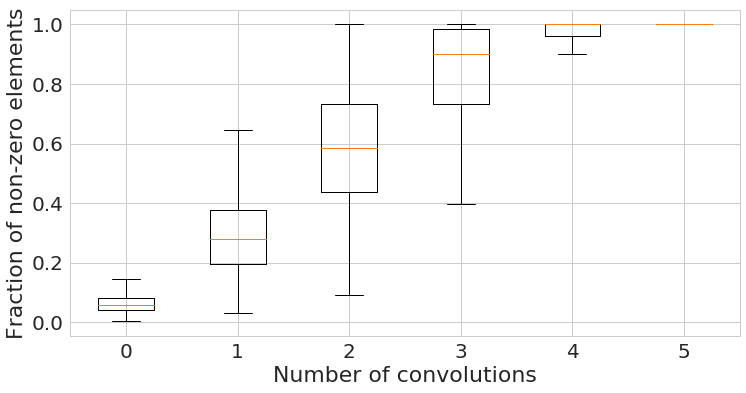

In [244]:
fig, axs = plt.subplots(figsize=(12, 6))
ax = plt.boxplot(frac_nnzs_bycat, labels=list(range(6)))
plt.xlabel('Number of convolutions')
plt.ylabel('Fraction of non-zero elements')

In [251]:
torch.rand(3, 1).expand(3, 10)


 0.2751  0.2751  0.2751  0.2751  0.2751  0.2751  0.2751  0.2751  0.2751  0.2751
 0.8636  0.8636  0.8636  0.8636  0.8636  0.8636  0.8636  0.8636  0.8636  0.8636
 0.6744  0.6744  0.6744  0.6744  0.6744  0.6744  0.6744  0.6744  0.6744  0.6744
[torch.FloatTensor of size 3x10]

In [211]:
33 * 33

1089

In [213]:
adj_pools[0][3].size

711

In [140]:
dataset = validation_datasets[0]

In [141]:
datavar = pagnn.datavargan.dataset_to_datavar(dataset, volatile=True)

In [142]:
noise = Variable(torch.FloatTensor(64, 100, 1).normal_(0, 1))

In [143]:
pred = net_g(noise, datavar.adjs)

In [144]:
pred_np = pagnn.to_numpy(pred)

In [145]:
dataset = validation_datasets[0]
seq = dataset.seqs[0]

seqs = []
steps = list(range(0, max(1, 512 - len(seq)), 20))
for offset in tqdm.tqdm_notebook(steps, total=len(steps)):
    start = offset
    stop = start + len(seq)
    assert stop <= 512, (start, stop, len(seq))
    datavar = pagnn.datavargan.dataset_to_datavar(dataset, volatile=True, offset=offset)
    noise = Variable(torch.FloatTensor(64, 100, 1).normal_(0, 1))
    pred = net_g(noise, datavar.adjs)
    ar = pagnn.to_numpy(pred)
    ar = ar[:, :, start:stop]
    seqs.extend([array_to_seq(ar[i]) for i in range(ar.shape[0])])

HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

In [180]:
img.tobytes()

img.

980

In [183]:
Image.Image

PIL.Image.Image

## Helpful functions

In [147]:
def get_offsets_from_array(ar):
    is_padding = np.all(ar == 0.05, axis=0)
    start = np.argmax(~is_padding)
    stop = len(is_padding) - np.argmax(~is_padding[::-1])
    return start, stop


ar = pred_np[0]
start, stop = get_offsets_from_array(ar)
assert np.all(ar[:, start - 1] == 1/20)
assert ~np.all(ar[:, start] == 1/20)
assert ~np.all(ar[:, stop - 1] == 1/20)
assert np.all(ar[:, stop] == 1/20)

In [148]:
def array_to_seq(ar):
    max_idxs = np.argmax(ar, 0)
    seq = ''.join(pagnn.utils.AMINO_ACIDS[i] for i in max_idxs)
    return seq

In [149]:
def get_seq(ar):
    start, stop = get_offsets_from_array(ar)
    ar = ar[:, start:stop]
    seq = array_to_seq(ar)
    return seq

In [ ]:
## 

In [253]:
from PIL import Image

In [255]:
img = Image.open('/tmp/image004.jpg')

In [257]:
img2 = Image.fromarray(np.vstack([img, img, img]))

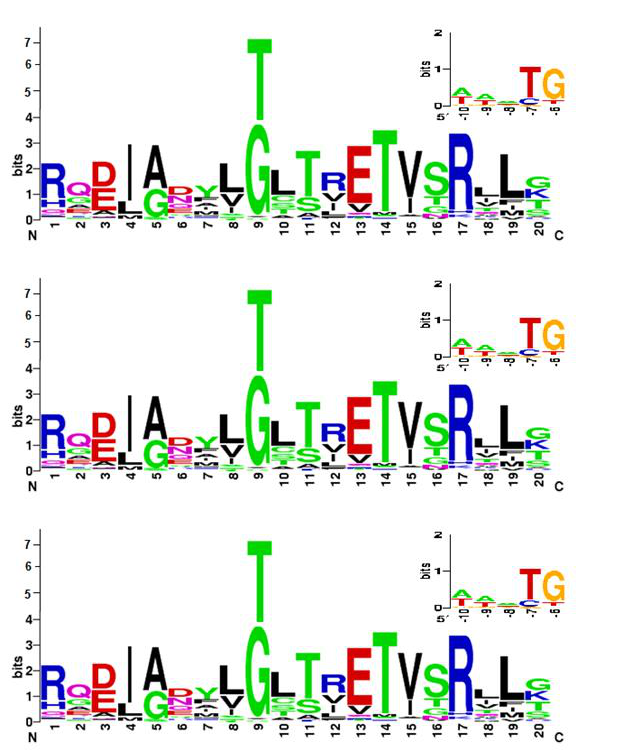

In [258]:
img2

In [366]:
np.equal.outer(ar1.argmax(axis=1), np.arange(ar1.shape[1])).transpose((0, 2, 1)).astype(int)

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 1, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 1, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])

In [364]:
ar1.max(axis=1, keepdims=1) == ar1

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        ..., 
        [False, False,  True, ..., False, False, False],
        [False,  True, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False,  True, False, ..., False, False, False],
        [False, False, False, ..., False,  True, False],
        [False, False, False, ..., False, False, False]],

       [[False,  True, False, ..., False, False,  True],
        [False, False, False, ..., False, False, False],
        [False, False,  True, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ...,  True, 

In [362]:
np.equal.outer(ar1.argmax(axis=1), np.arange(ar1.shape[1])).shape

(3, 100, 20)

In [266]:
ar1 = np.random.random((3, 20, 100))
ar2 = np.zeros((3, 20, 100))

In [315]:
np.argmax(ar1, 1)[:, None, :] == np.expand_dims(np.arange(20), 0)

/home/kimlab1/strokach/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


False

In [340]:
ar2t = ar2.transpose((0, 2, 1))

In [359]:
ar2.transpose((1, 2, 0))[np.argmax(ar1, 1)]

array([[[[ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         ..., 
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.]],

        [[ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         ..., 
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.]],

        [[ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         ..., 
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.]],

        ..., 
        [[ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         ..., 
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.]],

        [[ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         ..., 
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.]],

        [[ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         ..., 
         [ 1.,  1.,  1.],
  

In [357]:
ar2.transpose((1, 2, 0))[np.argmax(ar1, 1)] = 1

In [356]:
ar2 = np.zeros((3, 20, 100))

In [358]:
ar2

array([[[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ..., 
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ..., 
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ..., 
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]]])

In [317]:
np.expand_dims(np.arange(20), 0).shape

(1, 20)

In [319]:
ar1.argmax(axis=1)[:,None] == np.arange(ar1.shape[1])

/home/kimlab1/strokach/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


False

In [314]:
np.expand_dims(np.arange(20), 0).shape

(1, 20)

array([[0],
       [1],
       [2]])